# Seasonal Houston Count, Texas Air Pollution Analysis: IQR, Box Plot, Outliers

**Data Exploration and Cleanup**

The team and I set out to explore pollution measurements and discect data to answer the questions we had. My questions consisted on "differences in seasonal change?", "how bad is bad?", and "Percentage Annually we live in neautral/good air."
    
**Exploration**

EPA.gov provided full sample dataset via their API. The sample dataset consist of the county name searched from state and county number queried. EPA.gov API requests if a specific county is being queried, you must pass the two digit state number and three digit county number along with the Sample Data url. The numbers for county and state can be found in the list data url. <br><br>
    Sample data included site location measurements for nearly every hour of the day, for everyday of the year. The amount of information allowed me to seperate the data in many ways including by season. Measurements by the day, and hour, can provide the percentage of time we live in good or neatrual air. Lasly, every time frame includes sample measurements. EPA.gov has listed the PM 2.5 health index which informs us the severity levels in air pollution. Combining measurements with specific thresholds can give us answers on "How bad is bad?"
    
**Data Cleanup**

The json received from our API call includes a lot of parameters I immediately did not need. The following paramters are kept and used througout the dataset in various ways: "state_code", "state", "county_code", "county", "site_number", parameter", "sample_measurement", "units_of_measure", "latitude", "longitude","date_local", "time_local" "date_gmt", "time_gmt", "method_type", "method_code", "method", "date_of_last_change",  "cbsa_code". <br><br>
    Pandas, Matplotlib, Numpy, and a number of other libraries are used in this notebook. The index is set to date_gmt for date time indexing. Date_gmt is removed and replaced with site_number as times for certain plots. 
    One value had appeared to be a single outlier, of the outliers, in the California dataset. At a measurement of '995.6'. The value was one of 38400 measurements. It was removed at the beginning. <br><br>
    A column was added, named 'color'. The value inside represented the hex color value

*Spring runs from March 1 to May 31

*Summer runs from June 1 to August 31

*Fall (autumn) runs from September 1 to November 30

*Winter runs from Janurary 1 to February 28 (February 29 in a leap year).

In [139]:
%matplotlib inline

In [140]:
# Dependencies and Setup
import matplotlib.cbook as cbook
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

import json
import copy
from typing import List
import csv


Import saved csv. CSV includes data generated from 'StateCountySampleDataDF()' function.
Clean data.

In [141]:
# Import from .CSV
tx_hous_df = pd.read_csv("./csv_data/texas_houston.csv") 

In [142]:
# Verify california is in dataframe
assert tx_hous_df['state'][0] == 'Texas'

In [143]:
# Make copy before filtering
texas_filtered_df = tx_hous_df.copy()

In [144]:
texas_filtered_df.head()

,state_code,state,county_code,county,site_number,parameter,sample_measurement,units_of_measure,latitude,longitude,date_local,time_local,date_gmt,time_gmt,method_type,method_code,method,date_of_last_change,cbsa_code
0,48,Texas,201,Harris,24,Acceptable PM2.5 AQI & Speciation Mass,NaN,Micrograms/cubic meter (LC),29.901036,-95.326137,2019-01-01,00:00,2019-01-01,06:00,Non-FRM,702,PM2.5 SCC w/Correction Factor - TEOM Gravimetr...,2019-06-21,26420
1,48,Texas,201,Harris,24,Acceptable PM2.5 AQI & Speciation Mass,NaN,Micrograms/cubic meter (LC),29.901036,-95.326137,2019-01-01,01:00,2019-01-01,07:00,Non-FRM,702,PM2.5 SCC w/Correction Factor - TEOM Gravimetr...,2019-06-21,26420
2,48,Texas,201,Harris,24,Acceptable PM2.5 AQI & Speciation Mass,NaN,Micrograms/cubic meter (LC),29.901036,-95.326137,2019-01-01,02:00,2019-01-01,08:00,Non-FRM,702,PM2.5 SCC w/Correction Factor - TEOM Gravimetr...,2019-06-21,26420
3,48,Texas,201,Harris,24,Acceptable PM2.5 AQI & Speciation Mass,NaN,Micrograms/cubic meter (LC),29.901036,-95.326137,2019-01-01,03:00,2019-01-01,09:00,Non-FRM,702,PM2.5 SCC w/Correction Factor - TEOM Gravimetr...,2019-06-21,26420
4,48,Texas,201,Harris,24,Acceptable PM2.5 AQI & Speciation Mass,NaN,Micrograms/cubic meter (LC),29.901036,-95.326137,2019-01-01,04:00,2019-01-01,10:00,Non-FRM,702,PM2.5 SCC w/Correction Factor - TEOM Gravimetr...,2019-06-21,26420


In [145]:
texas_filtered_df.shape

(28744, 19)

### Clean dataset.

In [146]:
# Select certain columns to use for mapping, 
texas_filtered_df=texas_filtered_df[['county','site_number','sample_measurement','latitude','longitude','time_local','date_gmt','time_gmt','date_of_last_change']]
# Drop nan values and empty values
texas_filtered_df=texas_filtered_df.dropna()
# Remove all numbers below 0 and above 400
texas_filtered_df=texas_filtered_df[(texas_filtered_df[['sample_measurement']] > 0).all(axis=1) & (texas_filtered_df[['sample_measurement']] < 200).all(axis=1)]

In [147]:
tx_filtered_noIndexChange = texas_filtered_df

In [148]:
# Assign date_gmt DateTimeIndex. Allows for date searching throug index.
texas_filtered_df['date_gmt']=pd.DatetimeIndex(texas_filtered_df['date_gmt'])
#Set index to date_gmt
texas_filtered_df = texas_filtered_df.set_index('date_gmt')

In [149]:
texas_filtered_df.index

DatetimeIndex(['2019-01-11', '2019-01-12', '2019-01-12', '2019-01-12',
               '2019-01-12', '2019-01-12', '2019-01-12', '2019-01-12',
               '2019-01-12', '2019-01-12',
               ...
               '2019-08-13', '2019-08-19', '2019-09-01', '2019-09-06',
               '2019-09-12', '2019-09-20', '2019-09-22', '2019-09-24',
               '2019-09-26', '2019-09-30'],
              dtype='datetime64[ns]', name='date_gmt', length=25559, freq=None)

### Clean Copy dataset.

In [150]:
# Copy of clean data
tx_hous_clean_data = texas_filtered_df.copy()

### Add Column: Add Color to specific sample measurement
Used in scatter plot later.

In [151]:
# Color thresholds
colors_list = []
for row in tx_hous_clean_data['sample_measurement']:
    # if more than a value,
    if row > 55.5:
        # Append color value
        colors_list.append('#e80c0c')
    # else, if more than a value,
    elif row > 35.5:
        # Append color value
        colors_list.append('#e8970c')
    elif row > 12.1:
        # Append color value
        colors_list.append('#dbe36b')
    elif row > 0:
        # Append color value
        colors_list.append('#5cb85c')
    else:
        # Append a failing grade
        colors_list.append('Failed')
        #print(f'failed to apply color on row {row}')
        
# Create a column from the list
tx_hous_clean_data['color'] = colors_list

tx_hous_clean_data['color'].value_counts()

#5cb85c    20874
#dbe36b     4650
#e8970c       21
#e80c0c       14
Name: color, dtype: int64

In [152]:
# Check for Failed values. No Failed values.
assert any(tx_hous_clean_data['color'] == 'Failed') == False

* 32.669001,-94.167468 	= LA, CA. LA Department of Water and Power (1103)


In [153]:
tx_hous_clean_data.index.sort_values()

DatetimeIndex(['2019-01-01', '2019-01-01', '2019-01-01', '2019-01-01',
               '2019-01-01', '2019-01-01', '2019-01-01', '2019-01-01',
               '2019-01-01', '2019-01-01',
               ...
               '2020-01-01', '2020-01-01', '2020-01-01', '2020-01-01',
               '2020-01-01', '2020-01-01', '2020-01-01', '2020-01-01',
               '2020-01-01', '2020-01-01'],
              dtype='datetime64[ns]', name='date_gmt', length=25559, freq=None)

## Begin Season Sample Measurement Analysis
* Spring, Summer, Fall, Winter
    * Scatter Plot
    * IQR Results
    * Box Plots
    * Outliers

### Season: Spring

In [154]:
# Sort by date_gmt and time_gmt
spring_tx_hous = tx_hous_clean_data['2019-03-01':'2019-05-31']

**Reset index for and set new index for box plot.**

In [155]:
spring_tx_hous_box=spring_tx_hous.reset_index().set_index('site_number').sort_values(by=['site_number','time_gmt'], ascending=True)

### Plot: Spring

Input dataframe name below. Make loop later.

In [156]:
# dataframe to plot
plot_df = spring_tx_hous.copy()
#ax.plot(date, site_number_1103.sample_measurement)
plot_y_information = plot_df.sample_measurement

In [157]:
color_threshold = plot_df.color

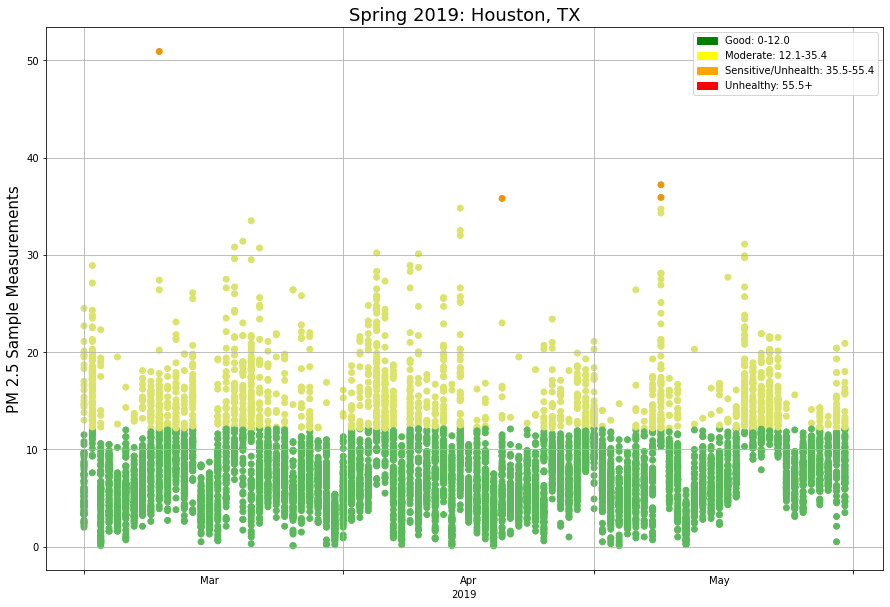

In [158]:
# Assigm date as index of dataframe. Dataframe index has dates
date = plot_df.index.astype('O')

# Data for plt
x = date
y = plot_y_information
c = color_threshold.values


# Plot subplots
fig, ax = plt.subplots(figsize=(15,10))
scatter = ax.scatter(x,y, c=c)

# Set month in xaxis by searching date format
ax.xaxis.set_major_locator(dates.MonthLocator())

# 16 is a slight approximation since months differ in number of days.
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

# loop for custom tickers. Assign marker size and center text
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

imid = len(plot_df) // 2
ax.set_xlabel(str(date[imid].year))
ax.set_ylabel('PM 2.5 Sample Measurements', size=15)
ax.set_title('Spring 2019: Houston, TX', size=18)
plt.grid(True)

# Labels for legend
green = mpatches.Patch(color='green', label='Good: 0-12.0')
yellow = mpatches.Patch(color='yellow', label='Moderate: 12.1-35.4')
orange = mpatches.Patch(color='orange', label='Sensitive/Unhealth: 35.5-55.4')
red = mpatches.Patch(color='red', label='Unhealthy: 55.5+')
#Call legend
plt.legend(handles = [green,yellow,orange,red])

# Save an image of the chart and print it to the screen
plt.savefig("./Images/TX_spring_pm25_scatter.png")
plt.show()

#### Site Number Seperation: Spring

In [159]:
host_site_num=['24','1035','1039','1050']

In [160]:
# Seperate by site_number
spring_tx_hous['site_number'].unique()
# Identify Site Number: 1103. Filter out values affiliated
spring_site_number_24=spring_tx_hous[(spring_tx_hous[['site_number']]==24).all(axis=1)]
spring_site_number_1035=spring_tx_hous[(spring_tx_hous[['site_number']]==1035).all(axis=1)]
spring_site_number_1039=spring_tx_hous[(spring_tx_hous[['site_number']]==1039).all(axis=1)]
spring_site_number_1050=spring_tx_hous[(spring_tx_hous[['site_number']]==1050).all(axis=1)]

In [161]:
spring_site_number_24=spring_site_number_24[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)
spring_site_number_1035=spring_site_number_1035[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)
spring_site_number_1039=spring_site_number_1039[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)
spring_site_number_1050=spring_site_number_1050[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)


In [162]:
# Make a list of site_numbers. Used in for loops to grab specific data by site number & used for new df header.
filtered_tx_hous_box_list = spring_tx_hous.site_number.sort_values().unique().tolist()

In [163]:
filtered_tx_hous_box_list

[24, 1035, 1039, 1050]

#### Begin IQR for Box Plots

In [164]:
# Look through sample measurement list and count the amount of mice in each drug regimen.
# Create an empty list to fill with for loop
measurement_quartile_spring=[]

# Search through filtered_ca_la_box_data with '.loc[site_number, 'sample_measurement' column]' and get the quartile
for i in filtered_tx_hous_box_list:
    location = spring_tx_hous_box.loc[i, 'sample_measurement'].quantile(q=[.25, .5, .75])
    # append results to measurement_quartile list before moving to next value in tumor_regimen_list
    measurement_quartile_spring.append(location)
measurement_quartile_spring

[0.25     5.025
 0.50     7.600
 0.75    11.300
 Name: sample_measurement, dtype: float64,
 0.25     6.5
 0.50     9.5
 0.75    13.5
 Name: sample_measurement, dtype: float64,
 0.25    4.7
 0.50    6.7
 0.75    9.7
 Name: sample_measurement, dtype: float64,
 0.25    4.7
 0.50    6.6
 0.75    9.4
 Name: sample_measurement, dtype: float64]

In [165]:
iqr_all_spring = []

# loop through measurement_quartile range (0-10). Find IQR by selecting one value at a time in the measurement_quartile list. 
for i in range(len(measurement_quartile_spring)):
    iqr = (measurement_quartile_spring[i][0.75])-(measurement_quartile_spring[i][0.25])
    # Append finding to iqr_all list before moving to next value
    iqr_all_spring.append(iqr)
#print(iqr_all_spring)

# Round numbers to 1 number after decimal.
round_iqr_all_spring = [round(num, 2) for num in iqr_all_spring]

In [166]:
# Show list. Verify we have correct amount
assert len(iqr_all_spring) == 4

**Header list MUST be numerical order. If not, labels will not match data. Order by site number**

In [167]:
# Column/Label list
headers_list=['High Meadows, TX (24)','NorthEast Houston (1035)','Southeast Houston (1039)','Seabrook, Texas (1050)']
# Combine both for loop generated list into one.
measurements_iqr_all_spring = [dict(zip(headers_list, round_iqr_all_spring))]
measurements_iqr_all_spring

[{'High Meadows, TX (24)': 6.28,
  'NorthEast Houston (1035)': 7.0,
  'Southeast Houston (1039)': 5.0,
  'Seabrook, Texas (1050)': 4.7}]

#### Begin Box Plots

In [168]:
# Values for plotting
box_values_spring = round_iqr_all_spring
# Sort to determine outliers
values_sorted_spring = sorted(box_values_spring)
print(values_sorted_spring)

[4.7, 5.0, 6.28, 7.0]


In [169]:
# Sample measurement values per site location
spring_site_24_measurements = spring_site_number_24['sample_measurement']
spring_site_1035_measurements = spring_site_number_1035['sample_measurement']
spring_site_1039_measurements = spring_site_number_1039['sample_measurement']
spring_site_1050_measurements = spring_site_number_1050['sample_measurement']

Number of Samples Measured: 7931


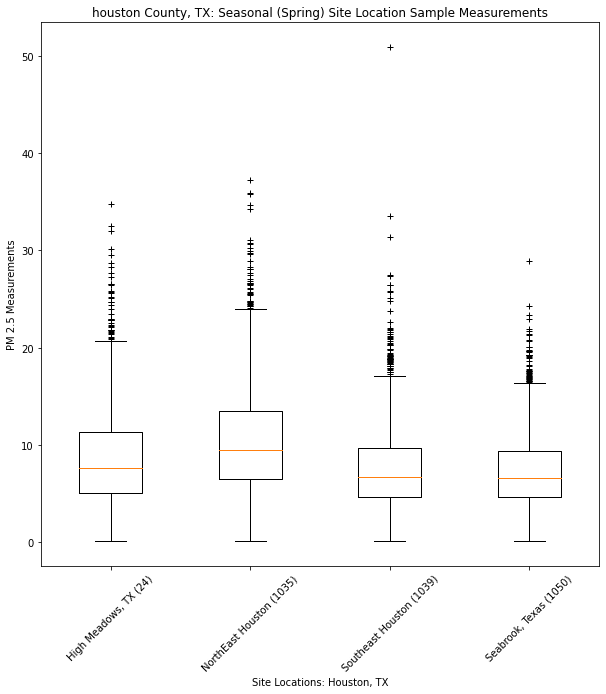

In [170]:
# Generate a box plot of the sample measurement of each site location, annually
# Plot info, from the cell above, must be in numberical order by site number for measurement_plot_info
measurement_plot_info = [spring_site_24_measurements,spring_site_1035_measurements,spring_site_1039_measurements,spring_site_1050_measurements]

fig, ax = plt.subplots(figsize=(10, 10))
pos = np.array(range(len(measurement_plot_info))) + 1
bp = ax.boxplot(measurement_plot_info, sym='k+', showfliers=True)

ax.set_xticklabels(headers_list, rotation=45)
ax.set_xlabel('Site Locations: Houston, TX')
ax.set_ylabel('PM 2.5 Measurements')
ax.set_title('houston County, TX: Seasonal (Spring) Site Location Sample Measurements')


plt.savefig("./Images/TX_spring_pm25_BoxPlot.png")
print(f'Number of Samples Measured: {len(spring_tx_hous)}')
plt.show()

#### Potential Outliers
Filtering by outlier values and dates may tell us which day/month of the year has larger than normal air pollution measurements. 

In [171]:
# High Meadows, TX (24) Outliers
hmeadows_spring_outliers = bp["fliers"][0].get_data()[1]
hmeadows_spring_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(spring_site_24_measurements)}')
print(f'Total amount of outliers: {len(hmeadows_spring_outliers)}')
print(f'Glendora Outlier values: {hmeadows_spring_outliers}')

Total amount samples in set: 1418
Total amount of outliers: 41
Glendora Outlier values: [20.9 21.  21.1 21.4 21.5 21.6 21.7 21.8 21.8 21.8 22.1 22.2 22.3 22.5
 22.8 22.8 22.9 23.  23.  23.5 24.  24.4 24.7 24.7 25.1 25.2 25.6 25.7
 25.8 26.4 26.6 26.6 27.3 27.7 28.3 28.7 29.5 30.1 32.  32.5 34.8]


In [172]:
# Northeast Houston, TX (1035) Outliers
nehouston_spring_outliers = bp["fliers"][1].get_data()[1]
nehouston_spring_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(spring_site_1035_measurements)}')
print(f'Total amount of outliers: {len(nehouston_spring_outliers)}')
print(f'Northeast Houston Outlier values: {nehouston_spring_outliers}')

Total amount samples in set: 2161
Total amount of outliers: 43
Northeast Houston Outlier values: [24.1 24.3 24.3 24.4 24.5 24.5 24.6 24.7 24.7 24.8 24.8 25.4 25.5 25.5
 25.6 25.7 26.  26.1 26.4 26.5 26.6 26.7 26.7 26.9 27.1 27.5 27.7 28.1
 28.1 28.3 28.9 29.6 29.7 29.9 30.2 30.7 30.8 31.1 34.3 34.7 35.8 35.9
 37.2]


In [173]:
# Southeast Houston, TX (1039) Outliers
sehouston_spring_outliers = bp["fliers"][2].get_data()[1]
sehouston_spring_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(spring_site_1039_measurements)}')
print(f'Total amount of outliers: {len(sehouston_spring_outliers)}')
print(f'Southeast Houston Outlier values: {sehouston_spring_outliers}')

Total amount samples in set: 2194
Total amount of outliers: 67
Southeast Houston Outlier values: [17.3 17.5 17.5 17.5 17.7 17.8 17.9 17.9 18.1 18.1 18.1 18.3 18.3 18.3
 18.4 18.5 18.5 18.6 18.6 18.7 18.7 18.8 18.8 18.8 18.8 18.8 18.9 18.9
 19.  19.1 19.1 19.1 19.2 19.2 19.4 19.5 19.8 19.9 19.9 20.3 20.3 20.4
 20.5 20.7 20.9 21.  21.1 21.2 21.4 21.6 21.6 21.8 21.9 22.  22.6 23.8
 24.8 25.1 25.7 25.8 26.4 26.4 27.4 27.5 31.4 33.5 50.9]


In [174]:
# Long Beach, CA (1050) Outliers
seabrook_spring_outliers = bp["fliers"][3].get_data()[1]
seabrook_spring_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(spring_site_1050_measurements)}')
print(f'Total amount of outliers: {len(seabrook_spring_outliers)}')
print(f'Long Beach Outlier values: {seabrook_spring_outliers}')

Total amount samples in set: 2158
Total amount of outliers: 51
Long Beach Outlier values: [16.5 16.6 16.6 16.6 16.7 16.8 16.8 16.9 16.9 17.  17.  17.1 17.1 17.2
 17.3 17.4 17.4 17.5 17.6 17.6 17.6 17.7 17.8 18.1 18.2 18.6 18.9 19.
 19.1 19.2 19.2 19.2 19.3 19.3 19.6 19.7 19.7 19.7 19.8 20.1 20.1 20.7
 20.8 21.3 21.4 21.7 21.9 23.  23.4 24.3 28.9]


### Season: Summer

In [175]:
# Sort by date_gmt and time_gmt
summer_tx_hous = tx_hous_clean_data['2019-06-01':'2019-08-31'].sort_values(["date_gmt", "time_gmt"])

**Reset index for and set new index for box plot.**

In [176]:
summer_tx_hous_box=summer_tx_hous.reset_index().set_index('site_number').sort_values(by=['site_number','time_gmt'], ascending=True)

### Plot: Summer

Input dataframe name below. Make loop later.

In [177]:
# dataframe to plot
plot_df = summer_tx_hous.copy()
#ax.plot(date, site_number_1103.sample_measurement)
plot_y_information = plot_df.sample_measurement

In [178]:
color_threshold = plot_df.color

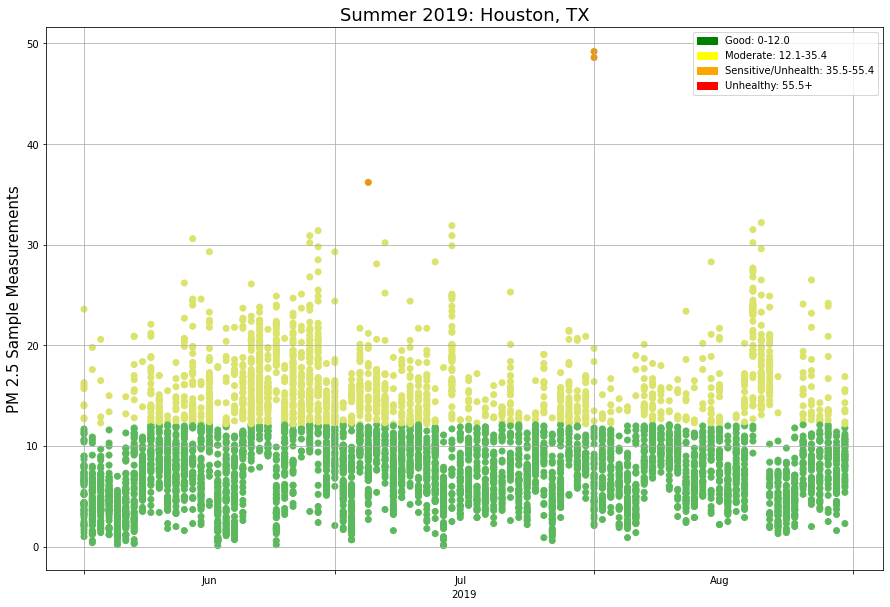

In [179]:
# Assigm date as index of dataframe. Dataframe index has dates
date = plot_df.index.astype('O')

# Data for plt
x = date
y = plot_y_information
c = color_threshold.values


# Plot subplots
fig, ax = plt.subplots(figsize=(15,10))
scatter = ax.scatter(x,y, c=c)

# Set month in xaxis by searching date format
ax.xaxis.set_major_locator(dates.MonthLocator())

# 16 is a slight approximation since months differ in number of days.
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

# loop for custom tickers. Assign marker size and center text
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

imid = len(plot_df) // 2
ax.set_xlabel(str(date[imid].year))
ax.set_ylabel('PM 2.5 Sample Measurements', size=15)
ax.set_title('Summer 2019: Houston, TX', size=18)
plt.grid(True)

# Labels for legend
green = mpatches.Patch(color='green', label='Good: 0-12.0')
yellow = mpatches.Patch(color='yellow', label='Moderate: 12.1-35.4')
orange = mpatches.Patch(color='orange', label='Sensitive/Unhealth: 35.5-55.4')
red = mpatches.Patch(color='red', label='Unhealthy: 55.5+')
#Call legend
plt.legend(handles = [green,yellow,orange,red])

# Save an image of the chart and print it to the screen
plt.savefig("./Images/TX_summer_pm25_scatter.png")
plt.show()

In [180]:
# Seperate by site_number
summer_tx_hous['site_number'].unique()
# Identify Site Number: 1103. Filter out values affiliated
summer_site_number_24=summer_tx_hous[(summer_tx_hous[['site_number']]==24).all(axis=1)]
summer_site_number_1035=summer_tx_hous[(summer_tx_hous[['site_number']]==1035).all(axis=1)]
summer_site_number_1039=summer_tx_hous[(summer_tx_hous[['site_number']]==1039).all(axis=1)]
summer_site_number_1050=summer_tx_hous[(summer_tx_hous[['site_number']]==1050).all(axis=1)]


In [181]:
summer_site_number_24=summer_site_number_24[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)
summer_site_number_1035=summer_site_number_1035[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)
summer_site_number_1039=summer_site_number_1039[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)
summer_site_number_1050=summer_site_number_1050[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)

In [182]:
# Make a list of site_numbers. Used in for loops to grab specific data by site number & used for new df header.
filtered_tx_hous_box_list = summer_tx_hous.site_number.sort_values().unique().tolist()
filtered_tx_hous_box_list

[24, 1035, 1039, 1050]

#### Begin IQR for Box Plots

In [183]:
# Look through sample measurement list and count the amount of mice in each drug regimen.
# Create an empty list to fill with for loop
measurement_quartile_summer=[]

# Search through filtered_ca_la_box_data with '.loc[site_number, 'sample_measurement' column]' and get the quartile
for i in filtered_tx_hous_box_list:
    location = summer_tx_hous_box.loc[i, 'sample_measurement'].quantile(q=[.25, .5, .75])
    # append results to measurement_quartile list before moving to next value in tumor_regimen_list
    measurement_quartile_summer.append(location)
measurement_quartile_summer

[0.25     7.90
 0.50     9.55
 0.75    12.95
 Name: sample_measurement, dtype: float64,
 0.25     7.300
 0.50    10.600
 0.75    14.475
 Name: sample_measurement, dtype: float64,
 0.25     5.0
 0.50     7.7
 0.75    11.0
 Name: sample_measurement, dtype: float64,
 0.25     5.1
 0.50     8.6
 0.75    12.6
 Name: sample_measurement, dtype: float64]

In [184]:
iqr_all_summer = []

# loop through measurement_quartile range (0-10). Find IQR by selecting one value at a time in the measurement_quartile list. 
for i in range(len(measurement_quartile_summer)):
    iqr = (measurement_quartile_summer[i][0.75])-(measurement_quartile_summer[i][0.25])
    # Append finding to iqr_all list before moving to next value
    iqr_all_summer.append(iqr)
#print(iqr_all_summer)

# Round numbers to 1 number after decimal.
round_iqr_all_summer = [round(num, 2) for num in iqr_all_summer]

In [185]:
# Show list. Verify we have correct amount
assert len(iqr_all_summer) == 4

In [186]:

# Combine both for loop generated list into one.
measurements_iqr_all_summer = [dict(zip(headers_list, round_iqr_all_summer))]
measurements_iqr_all_summer

[{'High Meadows, TX (24)': 5.05,
  'NorthEast Houston (1035)': 7.18,
  'Southeast Houston (1039)': 6.0,
  'Seabrook, Texas (1050)': 7.5}]

#### Begin Box Plots

In [187]:
# Values for plotting
box_values_summer = round_iqr_all_summer
# Sort to determine outliers
values_sorted_summer = sorted(box_values_summer)
print(values_sorted_summer)

[5.05, 6.0, 7.18, 7.5]


In [188]:
# Sample measurement values per site location
summer_site_24_measurements = summer_site_number_24['sample_measurement']
summer_site_1035_measurements = summer_site_number_1035['sample_measurement']
summer_site_1039_measurements = summer_site_number_1039['sample_measurement']
summer_site_1050_measurements = summer_site_number_1050['sample_measurement']

Number of Samples Measured: 5466


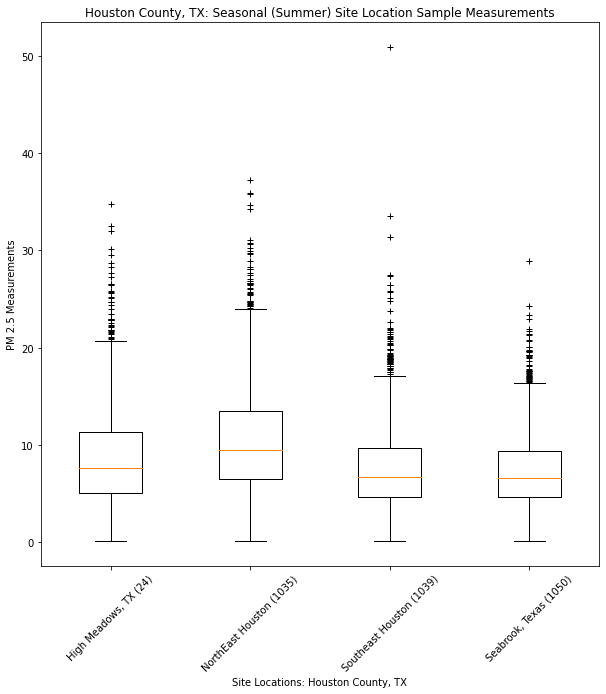

In [189]:
# Generate a box plot of the sample measurement of each site location, annually


fig, ax = plt.subplots(figsize=(10, 10))
pos = np.array(range(len(measurement_plot_info))) + 1
bp = ax.boxplot(measurement_plot_info, sym='k+', showfliers=True)

ax.set_xticklabels(headers_list, rotation=45)
ax.set_xlabel('Site Locations: Houston County, TX')
ax.set_ylabel('PM 2.5 Measurements')
ax.set_title('Houston County, TX: Seasonal (Summer) Site Location Sample Measurements')

plt.savefig("./Images/TX_summer_pm25_BoxPlot.png")
print(f'Number of Samples Measured: {len(summer_tx_hous)}')
plt.show()

#### Potential Outliers
Filtering by outlier values and dates may tell us which day/month of the year has larger than normal air pollution measurements. 

In [190]:
# High Meadows, TX (24) Outliers
hmeadows_summer_outliers = bp["fliers"][0].get_data()[1]
hmeadows_summer_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(summer_site_24_measurements)}')
print(f'Total amount of outliers: {len(hmeadows_summer_outliers)}')
print(f'High Meadows Outlier values: {hmeadows_summer_outliers}')

Total amount samples in set: 14
Total amount of outliers: 41
High Meadows Outlier values: [20.9 21.  21.1 21.4 21.5 21.6 21.7 21.8 21.8 21.8 22.1 22.2 22.3 22.5
 22.8 22.8 22.9 23.  23.  23.5 24.  24.4 24.7 24.7 25.1 25.2 25.6 25.7
 25.8 26.4 26.6 26.6 27.3 27.7 28.3 28.7 29.5 30.1 32.  32.5 34.8]


In [191]:
# Northeast Houston, TX (1035) Outliers
nehouston_summer_outliers = bp["fliers"][1].get_data()[1]
nehouston_summer_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(summer_site_1035_measurements)}')
print(f'Total amount of outliers: {len(nehouston_summer_outliers)}')
print(f'Northeast Houston Outlier values: {nehouston_summer_outliers}')

Total amount samples in set: 2190
Total amount of outliers: 43
Northeast Houston Outlier values: [24.1 24.3 24.3 24.4 24.5 24.5 24.6 24.7 24.7 24.8 24.8 25.4 25.5 25.5
 25.6 25.7 26.  26.1 26.4 26.5 26.6 26.7 26.7 26.9 27.1 27.5 27.7 28.1
 28.1 28.3 28.9 29.6 29.7 29.9 30.2 30.7 30.8 31.1 34.3 34.7 35.8 35.9
 37.2]


In [192]:
# Southeast Houston, TX (1039) Outliers
sehouston_summer_outliers = bp["fliers"][2].get_data()[1]
sehouston_summer_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(summer_site_1039_measurements)}')
print(f'Total amount of outliers: {len(sehouston_summer_outliers)}')
print(f'Southeast Houston Outlier values: {sehouston_summer_outliers}')

Total amount samples in set: 2191
Total amount of outliers: 67
Southeast Houston Outlier values: [17.3 17.5 17.5 17.5 17.7 17.8 17.9 17.9 18.1 18.1 18.1 18.3 18.3 18.3
 18.4 18.5 18.5 18.6 18.6 18.7 18.7 18.8 18.8 18.8 18.8 18.8 18.9 18.9
 19.  19.1 19.1 19.1 19.2 19.2 19.4 19.5 19.8 19.9 19.9 20.3 20.3 20.4
 20.5 20.7 20.9 21.  21.1 21.2 21.4 21.6 21.6 21.8 21.9 22.  22.6 23.8
 24.8 25.1 25.7 25.8 26.4 26.4 27.4 27.5 31.4 33.5 50.9]


In [193]:
# Seabrook, TX (1050) Outliers
seabrook_spring_outliers = bp["fliers"][3].get_data()[1]
seabrook_spring_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(summer_site_1050_measurements)}')
print(f'Total amount of outliers: {len(seabrook_spring_outliers)}')
print(f'Seabrook Outlier values: {seabrook_spring_outliers}')

Total amount samples in set: 1071
Total amount of outliers: 51
Seabrook Outlier values: [16.5 16.6 16.6 16.6 16.7 16.8 16.8 16.9 16.9 17.  17.  17.1 17.1 17.2
 17.3 17.4 17.4 17.5 17.6 17.6 17.6 17.7 17.8 18.1 18.2 18.6 18.9 19.
 19.1 19.2 19.2 19.2 19.3 19.3 19.6 19.7 19.7 19.7 19.8 20.1 20.1 20.7
 20.8 21.3 21.4 21.7 21.9 23.  23.4 24.3 28.9]


### Season: Fall

In [194]:
# Sort by date_gmt and time_gmt
fall_tx_hous = tx_hous_clean_data['2019-09-01':'2019-11-30'].sort_values(["date_gmt", "time_gmt"])

**Reset index for and set new index for box plot.**

In [195]:
fall_tx_hous_box=fall_tx_hous.reset_index().set_index('site_number').sort_values(by=['site_number','time_gmt'], ascending=True)

### Plot: Fall

Input dataframe name below. Make loop later.

In [196]:
# dataframe to plot
plot_df = fall_tx_hous.copy()
#ax.plot(date, site_number_1103.sample_measurement)
plot_y_information = plot_df.sample_measurement

In [197]:
color_threshold = plot_df.color

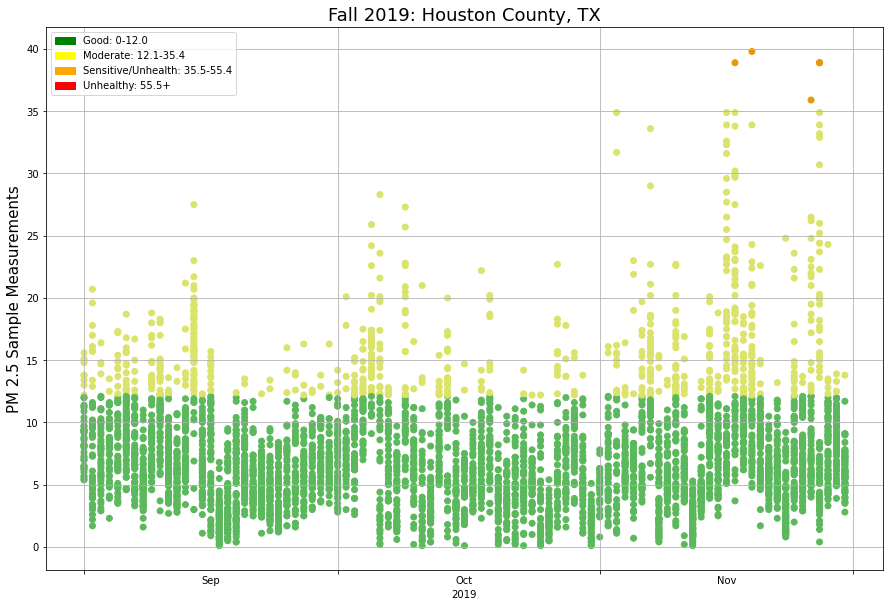

In [198]:
# Assigm date as index of dataframe. Dataframe index has dates
date = plot_df.index.astype('O')

# Data for plt
x = date
y = plot_y_information
c = color_threshold.values


# Plot subplots
fig, ax = plt.subplots(figsize=(15,10))
scatter = ax.scatter(x,y, c=c)

# Set month in xaxis by searching date format
ax.xaxis.set_major_locator(dates.MonthLocator())

# 16 is a slight approximation since months differ in number of days.
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

# loop for custom tickers. Assign marker size and center text
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

imid = len(plot_df) // 2
ax.set_xlabel(str(date[imid].year))
ax.set_ylabel('PM 2.5 Sample Measurements', size=15)
ax.set_title('Fall 2019: Houston County, TX', size=18)
plt.grid(True)

# Labels for legend
green = mpatches.Patch(color='green', label='Good: 0-12.0')
yellow = mpatches.Patch(color='yellow', label='Moderate: 12.1-35.4')
orange = mpatches.Patch(color='orange', label='Sensitive/Unhealth: 35.5-55.4')
red = mpatches.Patch(color='red', label='Unhealthy: 55.5+')
#Call legend
plt.legend(handles = [green,yellow,orange,red])

# Save an image of the chart and print it to the screen
plt.savefig("./Images/TX_fall_pm25_scatter.png")
plt.show()

#### Site Number Seperation: Fall

In [199]:
# Seperate by site_number
fall_tx_hous['site_number'].unique()
# Identify Site Number: 1103. Filter out values affiliated
fall_site_number_24=fall_tx_hous[(fall_tx_hous[['site_number']]==24).all(axis=1)]
fall_site_number_1035=fall_tx_hous[(fall_tx_hous[['site_number']]==1035).all(axis=1)]
fall_site_number_1039=fall_tx_hous[(fall_tx_hous[['site_number']]==1039).all(axis=1)]
fall_site_number_1050=fall_tx_hous[(fall_tx_hous[['site_number']]==1050).all(axis=1)]


In [200]:
fall_site_number_24=fall_site_number_24[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)
fall_site_number_1035=fall_site_number_1035[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)
fall_site_number_1039=fall_site_number_1039[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)
fall_site_number_1050=fall_site_number_1050[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)


In [201]:
# Make a list of site_numbers. Used in for loops to grab specific data by site number & used for new df header.
filtered_ca_la_box_list = fall_tx_hous.site_number.sort_values().unique().tolist()
filtered_ca_la_box_list

[24, 1035, 1039, 1050]

#### Begin IQR for Box Plots

In [202]:
# Look through sample measurement list and count the amount of mice in each drug regimen.
# Create an empty list to fill with for loop
measurement_quartile_fall=[]

# Search through filtered_ca_la_box_data with '.loc[site_number, 'sample_measurement' column]' and get the quartile
for i in filtered_tx_hous_box_list:
    location = fall_tx_hous_box.loc[i, 'sample_measurement'].quantile(q=[.25, .5, .75])
    # append results to measurement_quartile list before moving to next value in tumor_regimen_list
    measurement_quartile_fall.append(location)
measurement_quartile_fall

[0.25     7.05
 0.50     8.20
 0.75    10.45
 Name: sample_measurement, dtype: float64,
 0.25     5.1
 0.50     7.7
 0.75    11.3
 Name: sample_measurement, dtype: float64,
 0.25    3.9
 0.50    5.8
 0.75    8.5
 Name: sample_measurement, dtype: float64,
 0.25    4.7
 0.50    6.4
 0.75    9.1
 Name: sample_measurement, dtype: float64]

In [203]:
iqr_all_fall = []

# loop through measurement_quartile range (0-10). Find IQR by selecting one value at a time in the measurement_quartile list. 
for i in range(len(measurement_quartile_fall)):
    iqr = (measurement_quartile_fall[i][0.75])-(measurement_quartile_fall[i][0.25])
    # Append finding to iqr_all list before moving to next value
    iqr_all_fall.append(iqr)
#print(iqr_all_spring)

# Round numbers to 1 number after decimal.
round_iqr_all_fall = [round(num, 2) for num in iqr_all_fall]

In [204]:
# Show list. Verify we have correct amount
assert len(iqr_all_fall) == 4

In [205]:

# Combine both for loop generated list into one.
measurements_iqr_all_fall = [dict(zip(headers_list, round_iqr_all_fall))]
measurements_iqr_all_fall

[{'High Meadows, TX (24)': 3.4,
  'NorthEast Houston (1035)': 6.2,
  'Southeast Houston (1039)': 4.6,
  'Seabrook, Texas (1050)': 4.4}]

#### Begin Box Plots

In [206]:
# Values for plotting
box_values_fall = round_iqr_all_fall
# Sort to determine outliers
values_sorted_fall = sorted(box_values_fall)
print(values_sorted_fall)

[3.4, 4.4, 4.6, 6.2]


In [207]:
# Sample measurement values per site location
fall_site_24_measurements = fall_site_number_24['sample_measurement']
fall_site_1035_measurements = fall_site_number_1035['sample_measurement']
fall_site_1039_measurements = fall_site_number_1039['sample_measurement']
fall_site_1050_measurements = fall_site_number_1050['sample_measurement']


Number of Samples Measured: 5313


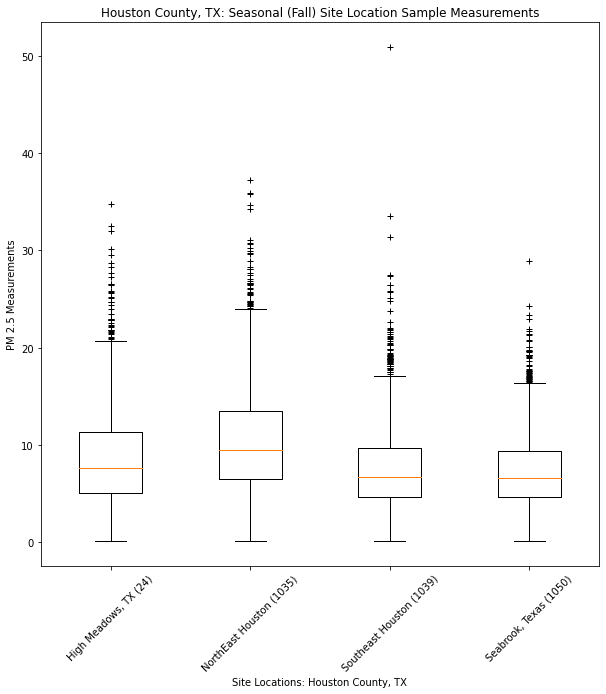

In [208]:
# Generate a box plot of the sample measurement of each site location, annually

fig, ax = plt.subplots(figsize=(10, 10))
pos = np.array(range(len(measurement_plot_info))) + 1
bp = ax.boxplot(measurement_plot_info, sym='k+', showfliers=True)

ax.set_xticklabels(headers_list, rotation=45)
ax.set_xlabel('Site Locations: Houston County, TX')
ax.set_ylabel('PM 2.5 Measurements')
ax.set_title('Houston County, TX: Seasonal (Fall) Site Location Sample Measurements')

plt.savefig("./Images/TX_fall_pm25_BoxPlot.png")
print(f'Number of Samples Measured: {len(fall_tx_hous)}')
plt.show()

#### Potential Outliers
Filtering by outlier values and dates may tell us which day/month of the year has larger than normal air pollution measurements. 

In [209]:
# High Meadows, TX (24) Outliers
hmeadows_fall_outliers = bp["fliers"][0].get_data()[1]
hmeadows_fall_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(fall_site_24_measurements)}')
print(f'Total amount of outliers: {len(hmeadows_fall_outliers)}')
print(f'High Meadows Outlier values: {hmeadows_fall_outliers}')

Total amount samples in set: 19
Total amount of outliers: 41
High Meadows Outlier values: [20.9 21.  21.1 21.4 21.5 21.6 21.7 21.8 21.8 21.8 22.1 22.2 22.3 22.5
 22.8 22.8 22.9 23.  23.  23.5 24.  24.4 24.7 24.7 25.1 25.2 25.6 25.7
 25.8 26.4 26.6 26.6 27.3 27.7 28.3 28.7 29.5 30.1 32.  32.5 34.8]


In [210]:
# Northeast Houston, TX (1035) Outliers
nehouston_fall_outliers = bp["fliers"][1].get_data()[1]
nehouston_fall_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(fall_site_1035_measurements)}')
print(f'Total amount of outliers: {len(nehouston_fall_outliers)}')
print(f'Northeast Houston Outlier values: {nehouston_fall_outliers}')

Total amount samples in set: 2132
Total amount of outliers: 43
Northeast Houston Outlier values: [24.1 24.3 24.3 24.4 24.5 24.5 24.6 24.7 24.7 24.8 24.8 25.4 25.5 25.5
 25.6 25.7 26.  26.1 26.4 26.5 26.6 26.7 26.7 26.9 27.1 27.5 27.7 28.1
 28.1 28.3 28.9 29.6 29.7 29.9 30.2 30.7 30.8 31.1 34.3 34.7 35.8 35.9
 37.2]


In [211]:
# Southeast Houston, TX (1039) Outliers
sehouston_fall_outliers = bp["fliers"][2].get_data()[1]
sehouston_fall_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(fall_site_1039_measurements)}')
print(f'Total amount of outliers: {len(sehouston_fall_outliers)}')
print(f'Southeast Houston Outlier values: {sehouston_fall_outliers}')

Total amount samples in set: 2151
Total amount of outliers: 67
Southeast Houston Outlier values: [17.3 17.5 17.5 17.5 17.7 17.8 17.9 17.9 18.1 18.1 18.1 18.3 18.3 18.3
 18.4 18.5 18.5 18.6 18.6 18.7 18.7 18.8 18.8 18.8 18.8 18.8 18.9 18.9
 19.  19.1 19.1 19.1 19.2 19.2 19.4 19.5 19.8 19.9 19.9 20.3 20.3 20.4
 20.5 20.7 20.9 21.  21.1 21.2 21.4 21.6 21.6 21.8 21.9 22.  22.6 23.8
 24.8 25.1 25.7 25.8 26.4 26.4 27.4 27.5 31.4 33.5 50.9]


In [212]:
# Seabrook, TX (1050) Outliers
seabrook_fall_outliers = bp["fliers"][3].get_data()[1]
seabrook_fall_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(fall_site_1050_measurements)}')
print(f'Total amount of outliers: {len(seabrook_fall_outliers)}')
print(f'Seabrook Outlier values: {seabrook_fall_outliers}')

Total amount samples in set: 1011
Total amount of outliers: 51
Seabrook Outlier values: [16.5 16.6 16.6 16.6 16.7 16.8 16.8 16.9 16.9 17.  17.  17.1 17.1 17.2
 17.3 17.4 17.4 17.5 17.6 17.6 17.6 17.7 17.8 18.1 18.2 18.6 18.9 19.
 19.1 19.2 19.2 19.2 19.3 19.3 19.6 19.7 19.7 19.7 19.8 20.1 20.1 20.7
 20.8 21.3 21.4 21.7 21.9 23.  23.4 24.3 28.9]


### Season: Winter

In [213]:
# Beginning of the year Winter
# Sort by date_gmt and time_gmt
winter_tx_hous = tx_hous_clean_data['2019-01-01':'2019-02'].sort_values(["date_gmt", "time_gmt"])
winter_tx_hous

,county,site_number,sample_measurement,latitude,longitude,time_local,time_gmt,date_of_last_change,color
date_gmt,,,,,,,,,
2019-01-01,Harris,1035,142.0,29.733726,-95.257593,00:00,06:00,2019-06-26,#e80c0c
2019-01-01,Harris,1039,128.1,29.670025,-95.128508,00:00,06:00,2019-06-21,#e80c0c
2019-01-01,Harris,1050,18.3,29.583047,-95.015544,00:00,06:00,2019-06-21,#dbe36b
2019-01-01,Harris,1039,121.0,29.670025,-95.128508,01:00,07:00,2019-06-21,#e80c0c
2019-01-01,Harris,1050,21.1,29.583047,-95.015544,01:00,07:00,2019-06-21,#dbe36b
...,...,...,...,...,...,...,...,...,...
2019-02-28,Harris,1050,2.6,29.583047,-95.015544,16:00,22:00,2019-06-26,#5cb85c
2019-02-28,Harris,24,3.5,29.901036,-95.326137,17:00,23:00,2019-06-26,#5cb85c
2019-02-28,Harris,1035,4.6,29.733726,-95.257593,17:00,23:00,2019-06-27,#5cb85c


**Reset index for and set new index for box plot.**

In [214]:
winter_tx_hous_box=winter_tx_hous.reset_index().set_index('site_number').sort_values(by=['site_number','time_gmt'], ascending=True)

### Plot: Winter

Input dataframe name below. Make loop later.

In [215]:
# dataframe to plot
plot_df = winter_tx_hous.copy()
#ax.plot(date, site_number_1103.sample_measurement)
plot_y_information = plot_df.sample_measurement

In [216]:
color_threshold = plot_df.color

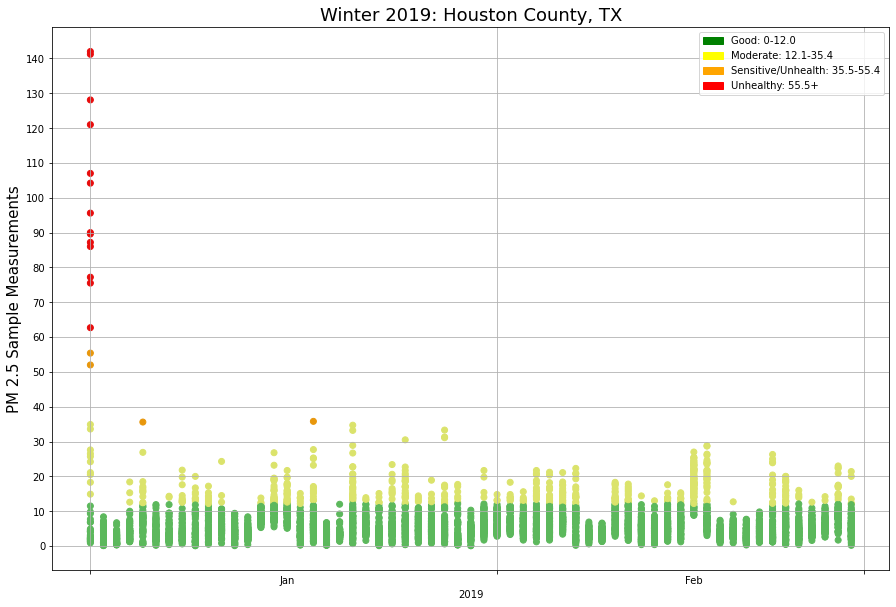

In [217]:
# Assigm date as index of dataframe. Dataframe index has dates
date = plot_df.index.astype('O')

# Data for plt
x = date
y = plot_y_information
c = color_threshold.values


# Plot subplots
fig, ax = plt.subplots(figsize=(15,10))
scatter = ax.scatter(x,y, c=c)

# Set month in xaxis by searching date format
ax.xaxis.set_major_locator(dates.MonthLocator())

# 16 is a slight approximation since months differ in number of days.
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

# loop for custom tickers. Assign marker size and center text
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

imid = len(plot_df) // 2
ax.set_xlabel(str(date[imid].year))
ax.set_ylabel('PM 2.5 Sample Measurements', size=15)
ax.set_yticks(range(0, 150, 10))
ax.set_title('Winter 2019: Houston County, TX', size=18)
plt.grid(True)

# Labels for legend
green = mpatches.Patch(color='green', label='Good: 0-12.0')
yellow = mpatches.Patch(color='yellow', label='Moderate: 12.1-35.4')
orange = mpatches.Patch(color='orange', label='Sensitive/Unhealth: 35.5-55.4')
red = mpatches.Patch(color='red', label='Unhealthy: 55.5+')
#Call legend
plt.legend(handles = [green,yellow,orange,red])

# Save an image of the chart and print it to the screen
plt.savefig("./Images/TX_winter_pm25_scatter.png")
plt.show()

In [218]:
# Seperate by site_number
winter_tx_hous['site_number'].unique()
# Identify Site Number: 1103. Filter out values affiliated
winter_site_number_24=winter_tx_hous[(winter_tx_hous[['site_number']]==24).all(axis=1)]
winter_site_number_1035=winter_tx_hous[(winter_tx_hous[['site_number']]==1035).all(axis=1)]
winter_site_number_1039=winter_tx_hous[(winter_tx_hous[['site_number']]==1039).all(axis=1)]
winter_site_number_1050=winter_tx_hous[(winter_tx_hous[['site_number']]==1050).all(axis=1)]


In [219]:
winter_site_number_24=winter_site_number_24[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)
winter_site_number_1035=winter_site_number_1035[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)
winter_site_number_1039=winter_site_number_1039[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)
winter_site_number_1050=winter_site_number_1050[['site_number','sample_measurement','time_gmt']].reset_index().set_index('site_number').sort_values(by=['time_gmt'], ascending=True)


In [220]:
# Make a list of site_numbers. Used in for loops to grab specific data by site number & used for new df header.
filtered_tx_hous_box_list = winter_tx_hous.site_number.sort_values().unique().tolist()
filtered_tx_hous_box_list

[24, 1035, 1039, 1050]

#### Begin IQR for Box Plots

In [221]:
# Look through sample measurement list and count the amount of mice in each drug regimen.
# Create an empty list to fill with for loop
measurement_quartile_winter=[]

# Search through filtered_ca_la_box_data with '.loc[site_number, 'sample_measurement' column]' and get the quartile
for i in filtered_tx_hous_box_list:
    location = winter_tx_hous_box.loc[i, 'sample_measurement'].quantile(q=[.25, .5, .75])
    # append results to measurement_quartile list before moving to next value in tumor_regimen_list
    measurement_quartile_winter.append(location)
measurement_quartile_winter

[0.25    3.5
 0.50    6.0
 0.75    9.9
 Name: sample_measurement, dtype: float64,
 0.25     4.1
 0.50     6.8
 0.75    10.6
 Name: sample_measurement, dtype: float64,
 0.25    3.2
 0.50    4.8
 0.75    7.2
 Name: sample_measurement, dtype: float64,
 0.25    3.1
 0.50    4.5
 0.75    6.6
 Name: sample_measurement, dtype: float64]

In [222]:
iqr_all_winter = []

# loop through measurement_quartile range (0-10). Find IQR by selecting one value at a time in the measurement_quartile list. 
for i in range(len(measurement_quartile_winter)):
    iqr = (measurement_quartile_winter[i][0.75])-(measurement_quartile_winter[i][0.25])
    # Append finding to iqr_all list before moving to next value
    iqr_all_winter.append(iqr)
#print(iqr_all_spring)

# Round numbers to 1 number after decimal.
round_iqr_all_winter = [round(num, 2) for num in iqr_all_winter]

In [223]:
# Show list. Verify we have correct amount
assert len(iqr_all_winter) == 4

In [224]:
# Combine both for loop generated list into one.
measurements_iqr_all_winter = [dict(zip(headers_list, round_iqr_all_winter))]
measurements_iqr_all_winter

[{'High Meadows, TX (24)': 6.4,
  'NorthEast Houston (1035)': 6.5,
  'Southeast Houston (1039)': 4.0,
  'Seabrook, Texas (1050)': 3.5}]

#### Begin Box Plots

In [225]:
# Values for plotting
box_values_winter = round_iqr_all_winter
# Sort to determine outliers
values_sorted_winter = sorted(box_values_winter)
print(values_sorted_winter)

[3.5, 4.0, 6.4, 6.5]


In [226]:
# Sample measurement values per site location
winter_site_24_measurements = winter_site_number_24['sample_measurement']
winter_site_1035_measurements = winter_site_number_1035['sample_measurement']
winter_site_1039_measurements = winter_site_number_1039['sample_measurement']
winter_site_1050_measurements = winter_site_number_1050['sample_measurement']


Number of Samples Measured: 5327


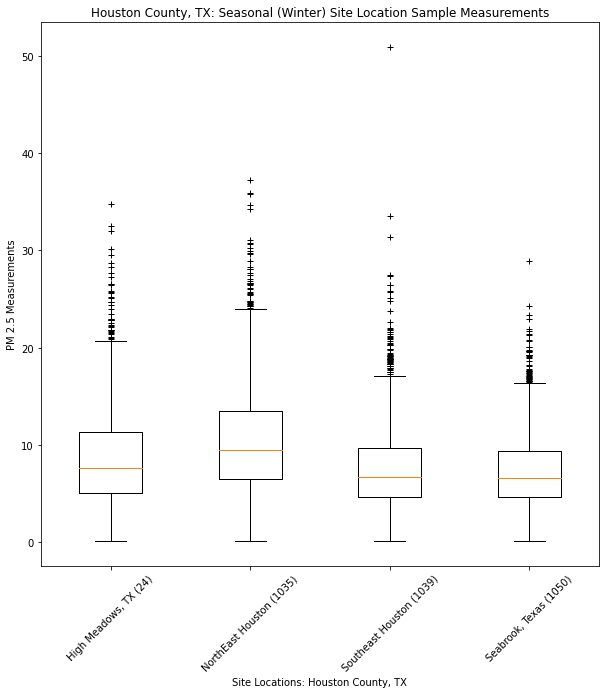

In [227]:
# Generate a box plot of the sample measurement of each site location, annually

fig, ax = plt.subplots(figsize=(10, 10))
pos = np.array(range(len(measurement_plot_info))) + 1
bp = ax.boxplot(measurement_plot_info, sym='k+', showfliers=True)

ax.set_xticklabels(headers_list, rotation=45)
ax.set_xlabel('Site Locations: Houston County, TX')
ax.set_ylabel('PM 2.5 Measurements')
ax.set_title('Houston County, TX: Seasonal (Winter) Site Location Sample Measurements')

plt.savefig("./Images/TX_winter_pm25_BoxPlot.png")
print(f'Number of Samples Measured: {len(winter_tx_hous)}')
plt.show()

#### Potential Outliers
Filtering by outlier values and dates may tell us which day/month of the year has larger than normal air pollution measurements. 

In [228]:
# High Meadows, TX (24) Outliers
hmeadows_winter_outliers = bp["fliers"][0].get_data()[1]
hmeadows_winter_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(winter_site_24_measurements)}')
print(f'Total amount of outliers: {len(hmeadows_winter_outliers)}')
print(f'High Meadows Outlier values: {hmeadows_winter_outliers}')

Total amount samples in set: 1152
Total amount of outliers: 41
High Meadows Outlier values: [20.9 21.  21.1 21.4 21.5 21.6 21.7 21.8 21.8 21.8 22.1 22.2 22.3 22.5
 22.8 22.8 22.9 23.  23.  23.5 24.  24.4 24.7 24.7 25.1 25.2 25.6 25.7
 25.8 26.4 26.6 26.6 27.3 27.7 28.3 28.7 29.5 30.1 32.  32.5 34.8]


In [229]:
# Northeast Houston, TX (1035) Outliers
nehouston_winter_outliers = bp["fliers"][1].get_data()[1]
nehouston_winter_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(winter_site_1035_measurements)}')
print(f'Total amount of outliers: {len(nehouston_winter_outliers)}')
print(f'Northeast Houston Outlier values: {nehouston_winter_outliers}')

Total amount samples in set: 1391
Total amount of outliers: 43
Northeast Houston Outlier values: [24.1 24.3 24.3 24.4 24.5 24.5 24.6 24.7 24.7 24.8 24.8 25.4 25.5 25.5
 25.6 25.7 26.  26.1 26.4 26.5 26.6 26.7 26.7 26.9 27.1 27.5 27.7 28.1
 28.1 28.3 28.9 29.6 29.7 29.9 30.2 30.7 30.8 31.1 34.3 34.7 35.8 35.9
 37.2]


In [230]:
# Southeast Houston, TX (1039) Outliers
sehouston_winter_outliers = bp["fliers"][2].get_data()[1]
sehouston_winter_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(winter_site_1039_measurements)}')
print(f'Total amount of outliers: {len(sehouston_winter_outliers)}')
print(f'Southeast Houston Outlier values: {sehouston_winter_outliers}')

Total amount samples in set: 1394
Total amount of outliers: 67
Southeast Houston Outlier values: [17.3 17.5 17.5 17.5 17.7 17.8 17.9 17.9 18.1 18.1 18.1 18.3 18.3 18.3
 18.4 18.5 18.5 18.6 18.6 18.7 18.7 18.8 18.8 18.8 18.8 18.8 18.9 18.9
 19.  19.1 19.1 19.1 19.2 19.2 19.4 19.5 19.8 19.9 19.9 20.3 20.3 20.4
 20.5 20.7 20.9 21.  21.1 21.2 21.4 21.6 21.6 21.8 21.9 22.  22.6 23.8
 24.8 25.1 25.7 25.8 26.4 26.4 27.4 27.5 31.4 33.5 50.9]


In [231]:
# Seabrook, TX (1050) Outliers
seabrook_winter_outliers = bp["fliers"][3].get_data()[1]
seabrook_winter_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(winter_site_1050_measurements)}')
print(f'Total amount of outliers: {len(seabrook_winter_outliers)}')
print(f'Seabrook Outlier values: {seabrook_winter_outliers}')

Total amount samples in set: 1390
Total amount of outliers: 51
Seabrook Outlier values: [16.5 16.6 16.6 16.6 16.7 16.8 16.8 16.9 16.9 17.  17.  17.1 17.1 17.2
 17.3 17.4 17.4 17.5 17.6 17.6 17.6 17.7 17.8 18.1 18.2 18.6 18.9 19.
 19.1 19.2 19.2 19.2 19.3 19.3 19.6 19.7 19.7 19.7 19.8 20.1 20.1 20.7
 20.8 21.3 21.4 21.7 21.9 23.  23.4 24.3 28.9]
